In [1]:
import numpy as np
import torch
from hmc_u1_torch_ft import HMC_U1
from nn_model import NNFieldTransformation
from utils import plot_results, compute_autocorrelation_by_def, plaquette_value, calculate_plaquette_from_field


In [2]:
# Parameters
""" 
total_time = n_steps * step_size should be around 1 to 2 units.
If the energy conservation is not good, try to reduce the step size.
"""

lattice_size = 16
volume = lattice_size ** 2
beta = 3
n_thermalization_steps = 100
n_steps = 100
step_size = 0.01
n_iterations = 200

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### No Field Transformation

>>> No Field Transformation


Running HMC: 100%|██████████| 200/200 [00:06<00:00, 28.99it/s]


Expected plaquette value for beta = 3: 0.8099852939565045
Real plaquette value from final configuration: 0.8210562266987215


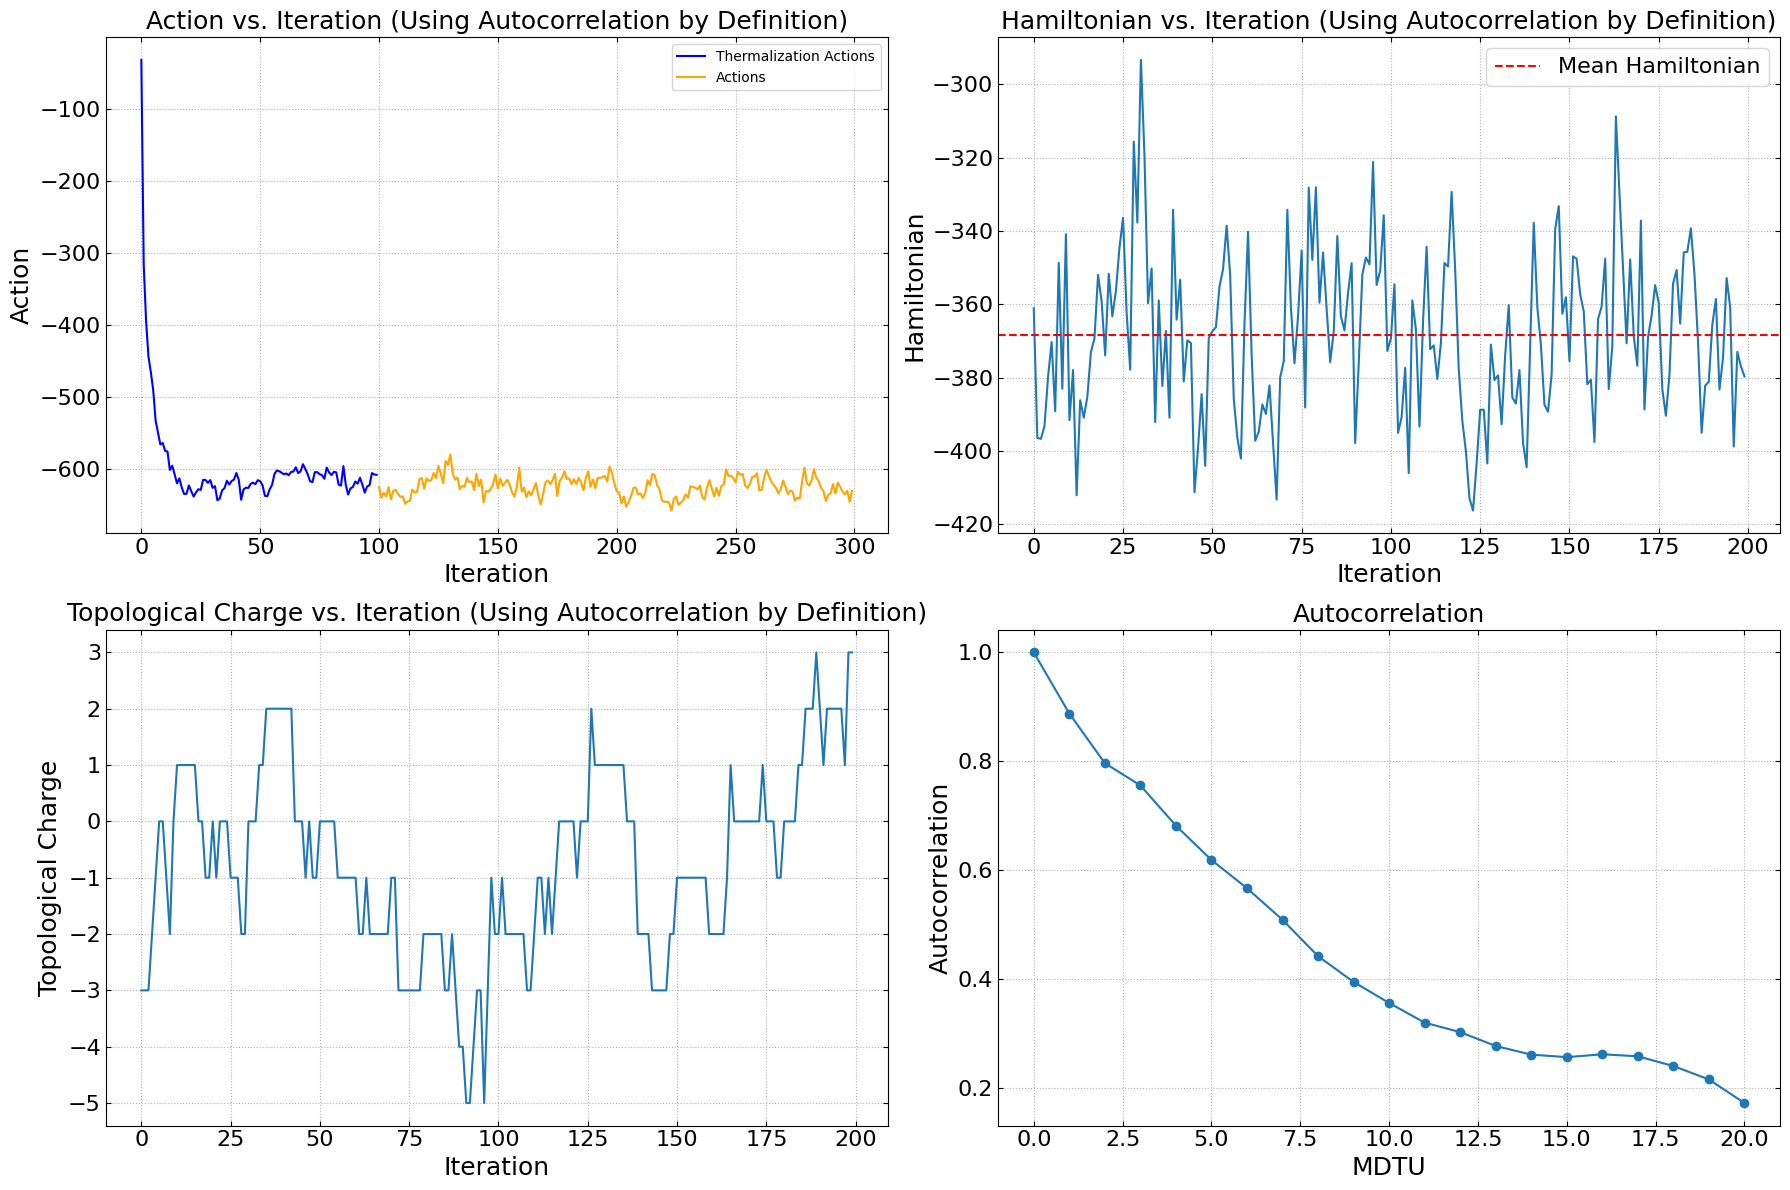

Thermalization acceptance rate: 0.9900
Acceptance rate: 1.0000
Relative variation of Hamiltonian (delta H / H_mean): -0.3337
Variation of topological charge (delta Q): 8.0000
>>> Simulation completed


In [3]:
print(">>> No Field Transformation")

# Initialize HMC
hmc = HMC_U1(lattice_size, beta, n_thermalization_steps, n_steps, step_size, device=device)

# Thermalize the system
theta_thermalized, thermalization_actions, thermalization_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, actions, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

# Convert to numpy arrays
thermalization_actions = thermalization_actions.cpu().numpy()
actions = actions.cpu().numpy()
hamiltonians = hamiltonians.cpu().numpy()
final_config = final_config.cpu().numpy()
topological_charges = topological_charges.cpu().numpy()

# Calculate expected and actual plaquette values
expected_plaquette = plaquette_value(beta)
real_plaquette = calculate_plaquette_from_field(final_config)
print(f"Expected plaquette value for beta = {beta}: {expected_plaquette}")
print(f"Real plaquette value from final configuration: {real_plaquette}")

# Compute autocorrelation of topological charges
max_lag = 20
autocorrelations = compute_autocorrelation_by_def(topological_charges, max_lag)

# Plot results
plot_results(thermalization_actions, actions, topological_charges, hamiltonians, autocorrelations, title_suffix="(Using Autocorrelation by Definition)")

# Print acceptance rates
print(f"Thermalization acceptance rate: {thermalization_acceptance_rate:.4f}")
print(f"Acceptance rate: {acceptance_rate:.4f}")

# Calculate and print relative change in Hamiltonian (delta H)
delta_H = np.max(hamiltonians) - np.min(hamiltonians)
H_mean = np.mean(hamiltonians)
relative_delta_H = delta_H / H_mean
print(f"Relative variation of Hamiltonian (delta H / H_mean): {relative_delta_H:.4f}")

# Calculate and print change in topological charge (delta Q)
delta_Q = np.max(topological_charges) - np.min(topological_charges)
print(f"Variation of topological charge (delta Q): {delta_Q:.4f}")

print(">>> Simulation completed")

### Neural Network Field Transformation

/home/jinchen/miniconda3/envs/lat/lib/python3.9/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


>>> Neural Network Field Transformation


Training Neural Network:  17%|█▋        | 87/500 [00:00<00:01, 212.18it/s]

Training Neural Network: 100%|██████████| 500/500 [00:01<00:00, 334.20it/s]


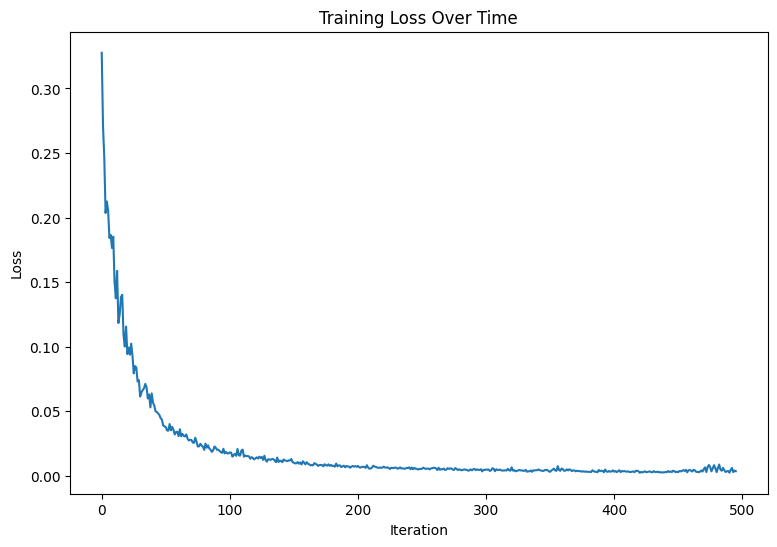

Running HMC: 100%|██████████| 200/200 [09:00<00:00,  2.70s/it]


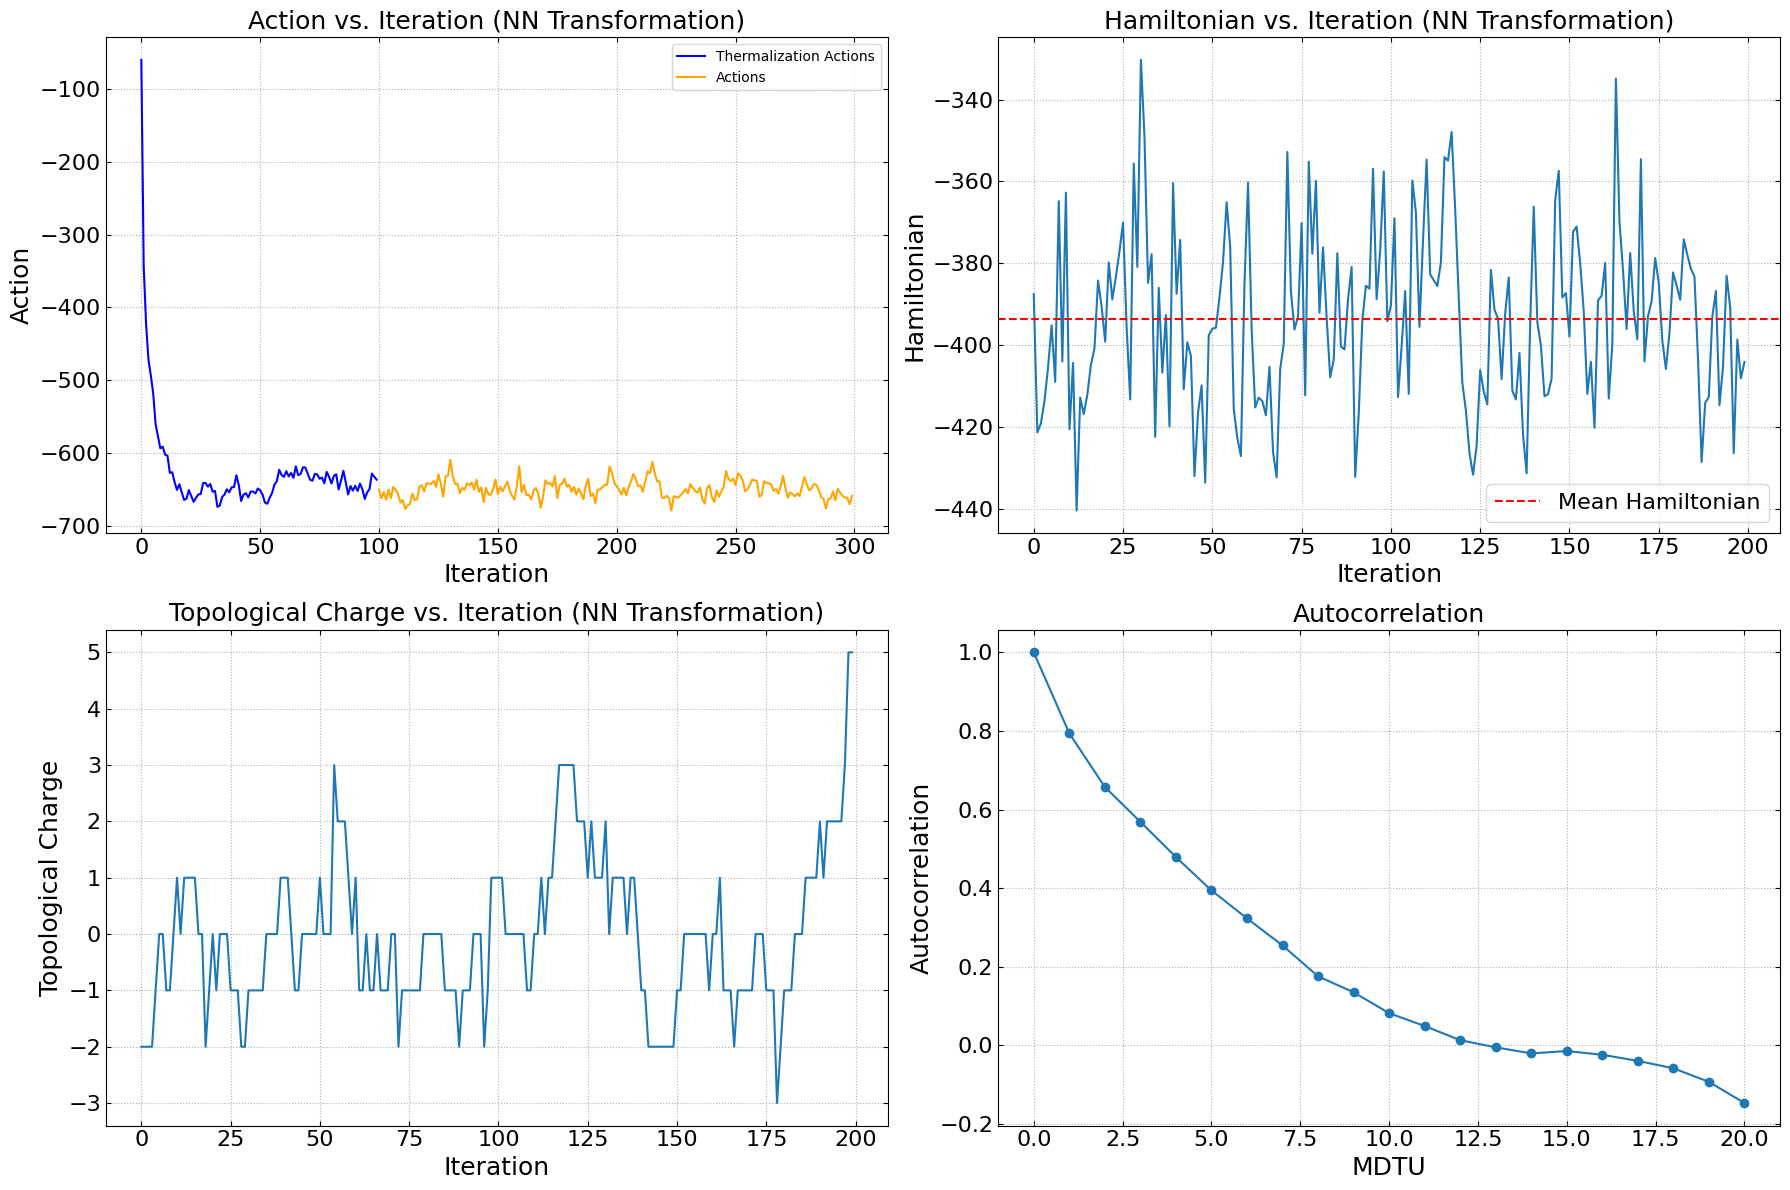

Thermalization acceptance rate: 0.9900
Acceptance rate: 1.0000
Relative variation of Hamiltonian (delta H / H_mean): -0.2799
Variation of topological charge (delta Q): 8.0000
>>> Simulation completed


In [4]:
print(">>> Neural Network Field Transformation")

# Train the neural network force
nn_transformation = NNFieldTransformation(lattice_size, model_type='CNN', device=device)
nn_transformation.train(beta, n_iterations=500)

# Initialize HMC
hmc = HMC_U1(lattice_size, beta, n_thermalization_steps, n_steps, step_size, field_transformation=nn_transformation, device=device)

# Thermalize the system with field transformation
theta_thermalized, thermalization_actions, thermalization_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation (using thermalized configuration)
final_config, actions, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

# Convert to numpy arrays
thermalization_actions = thermalization_actions.cpu().numpy()
actions = actions.cpu().numpy()
hamiltonians = hamiltonians.cpu().numpy()
final_config = final_config.cpu().numpy()
topological_charges = topological_charges.cpu().numpy()

# Compute autocorrelation of the topological charge
max_lag = 20
autocorrelations = compute_autocorrelation_by_def(topological_charges, max_lag)

# Plot results
plot_results(thermalization_actions, actions, topological_charges, hamiltonians, autocorrelations, title_suffix="(NN Transformation)")

# Print the acceptance rate
print(f"Thermalization acceptance rate: {thermalization_acceptance_rate:.4f}")
print(f"Acceptance rate: {acceptance_rate:.4f}")

# Calculate and print the variation of Hamiltonian (delta H) relative to mean H
delta_H = np.max(hamiltonians) - np.min(hamiltonians)
H_mean = np.mean(hamiltonians)
relative_delta_H = delta_H / H_mean
print(f"Relative variation of Hamiltonian (delta H / H_mean): {relative_delta_H:.4f}")

# Calculate and print the variation of topological charge (delta Q)
delta_Q = np.max(topological_charges) - np.min(topological_charges)
print(f"Variation of topological charge (delta Q): {delta_Q:.4f}")

print(">>> Simulation completed")